In [1]:
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from time import sleep
pick_from = np.random.choice
from os import mkdir 
import pandas as pd

In [2]:
import time

In [3]:
import matplotlib.animation as animation 
from IPython import display

In [4]:
class DiseaseState(Enum):
    '''enumerates disease state of agents'''
    HUMAN = 2
    ZOMBIE = 1
    CURED = 0
    DEAD = 3
    
def get_name(a):
    return(a.name)
def get_value(a):
    return(a.value)
v_get_name = np.vectorize(get_name)
v_get_value = np.vectorize(get_value)

In [5]:
class SZR():
    '''
    A Suseptible-Zombie-Recovered Random walk model
    '''

    def __init__(self, population=683, infected=1, q=0.9, nx=50, ny=50):
        '''
        Attribute:
            population: population of the a 'isolated' town. 
                        it is assumed no one gets in or out.
            infected:   how many agents are infected at the start of the simulation
        '''

        self.q = q
        self.infected = infected
        self.make_walls(nx, ny)
        self.make_agents(population)
        self.put_in_seed_zombie(infected)
        # self.kill_immunize(1)
        self.make_legal_moves()

    def make_legal_moves(self):
        '''
        initiates helper attributes to move the agents
        creates:
            moves : human readable move keywords
            move_increments : move values in numbers; up =[0,1] etc.
            move_dict ={moves:move_increment}
            we also add an option 'no_move'= [0,0] where agent doesnt move 
        '''
        self.moves = ['up', 'down', 'left', 'right']
        self.moves_increments = [[0, 1], [0, -1], [-1, 0], [1, 0]]
        self.move_dict = {a: b for a, b in zip(
            self.moves, self.moves_increments)}
        self.move_dict['no_move'] = [0, 0]

    def put_in_seed_zombie(self, infected):
        '''
        converts infected number of agents to zombies who can now infect healthy agents
        '''
        # use 'replace = False ' to pick unique agents to infect
        who_is_zombified = pick_from(self.id, infected, replace=False)
        self.infection_status[who_is_zombified] = DiseaseState.ZOMBIE
        # print(self.infection_status)

    def make_agents(self, population):
        '''
        makes arrays representing a population of size N the 
            id: identifier of the agent, array len=N
            loc : location of the agent on the map  array[N,2]
            infection_status : is the agent infected, len=N 
                               we initiate the whole population as healthy 
                               0 : zombie scum
                               1 : healthy/suspetible
                               2 : cured (she turned me into a newt, 
                                          but i got better)
                               3 : the grateful dead
         '''
        self.population = population
        self.id = np.arange(self.population)

        possible_x_locs = np.arange(self.nx)
        possible_y_locs = np.arange(self.ny)
        self.xlocs = pick_from(possible_x_locs, self.population)
        self.ylocs = pick_from(possible_x_locs, self.population)
        # above we could simply have written
        # xlocs = np.random.choice(self.nx, self.population)
        # but it might be complex to read

        #self.location = np.array([xlocs, ylocs])

        self.infection_status = np.full(self.population, DiseaseState.HUMAN)

    def kill_immunize(self, k):
        '''
        for testing: kills one  random agent          
        '''
        who_is_killed = pick_from(self.id, k)
        self.infection_status[who_is_killed] = DiseaseState.DEAD
        who_is_immunized = pick_from(self.id, k)
        self.infection_status[who_is_immunized] = DiseaseState.CURED

    def make_walls(self, nx, ny):
        '''
        stores the number of grid points (nx, ny)
        and top(ny-1), bottom(0), left(0), and right(nx-1) wall positions.
        all the 'agents' spawn and move single step up, down, right or left
        '''
        self.nx = nx  # number of x grid points
        self.ny = ny  # number of y grid points
        self.topwall = ny-1
        self.bottomwall = 0
        self.leftwall = 0
        self.rightwall = nx-1

    def beautify_grid(self, ax):
        ax.set_xlim([-1, self.nx])
        ax.set_ylim([-1, self.ny])
        ax.grid(linestyle='--', alpha=0.3)
        ax.set_aspect('equal')

    def get_x_y(self, inf_status):
        selected = np.where(self.infection_status == inf_status)
        x = self.xlocs[selected]
        y = self.ylocs[selected]
        return(x, y)

    def plot_locs(self, ax, **kwargs):
        colors = {'HUMAN': 'green', 'ZOMBIE': 'red',
                  'CURED': 'cyan', 'DEAD': 'black'}
        s = {'HUMAN': 5, 'ZOMBIE': 3, 'CURED': 7, 'DEAD': 10}

        color = [colors[i.name] for i in self.infection_status]
        s = [i.value*20+3 for i in self.infection_status]

        # s=
        '''
        for inf_status in [0,1,2]:
            x,y=self.get_x_y(inf_status)
            ax.scatter(x,y,color=c[inf_status],**kwargs)
        '''
        ax.scatter(self.xlocs, self.ylocs, color=color,
                   s=s, alpha=0.5)
        self.beautify_grid(ax)

    def move_agents(self):
        '''
        moves each agent, alive and zombified one step, up , down, left or right
        the dead agents dont move
        if any of them move outside town they are brought back in 
        '''
        # select random walk for all agents
        steps_ = pick_from(self.moves, self.population)
        # print(self.infection_status,'\n',steps)

        # finds where which agents are dead , set them to no move and keep the other moves
        steps_ = np.where(self.infection_status ==
                          DiseaseState.DEAD, 'no_move', steps_)
        # print(steps)
        # convert steps from strings to move steps
        # and transpose so it can be easily added to xlocs and ylocs
        steps = np.array([self.move_dict[i] for i in steps_]).T
        new_xlocs = steps[0]+self.xlocs
        new_ylocs = steps[1]+self.ylocs
        # print(new_xlocs,self.xlocs)
        # print(new_ylocs,self.ylocs)

        # check for illegal moves
        illegalx = np.where(new_xlocs < self.leftwall)
        new_xlocs[illegalx] = self.leftwall
        illegalx = np.where(new_xlocs > self.rightwall)
        new_xlocs[illegalx] = self.rightwall
        illegaly = np.where(new_ylocs < self.bottomwall)
        new_ylocs[illegaly] = self.bottomwall
        illegaly = np.where(new_ylocs > self.topwall)
        new_ylocs[illegaly] = self.topwall

        return(new_xlocs, new_ylocs, steps_)

    @classmethod
    def to_tuple(cls, a):
        return ([tuple(i) for i in a])

    @classmethod
    def common_coordinates(cls, a, b):
        '''
        takes two lists of coordinates and returns the coordates that are in common
        as we use set operations each element of the list is converted to a tuple 
        '''
        #nptuple = np.vectorize(tuple)
        a = set(cls.to_tuple(a))
        b = set(cls.to_tuple(b))
        common = a.intersection(b)
        common = [i for i in common]
        return(common)

    def check_infected_contact(self):
        '''
        checks if zombies comes in contact with a healthy agent
        '''

        #multiple_agent_locs = self.check_where_agents_meets()

        infected_id = np.where(self.infection_status == DiseaseState.ZOMBIE)
        #  infected_locs are where zombies are present
        infected_locs = np.array(
            [self.xlocs[infected_id], self.ylocs[infected_id]]).T
        #print('locations where zombies are present:', infected_locs)

        human_id = np.where(self.infection_status == DiseaseState.HUMAN)
        #  human_locs are where zombies are present
        human_locs = np.array(
            [self.xlocs[human_id], self.ylocs[human_id]]).T
        #print('locations where humans are present:', human_locs)

        # find where both humans and zombies are present
        infection_contact_locs = self.common_coordinates(
            human_locs, infected_locs)
        print('locations where both humans and zombies are present:',
              infection_contact_locs)

        return(infection_contact_locs)

    def spread_infection(self, compounded=False):
        '''
        this is how we spread the disease. 
         1. find where zombies are. [infected locs]
         2. find if there are humans at these locations.
         3. if a location is infected and there are 
            humans (suspetible) present, then try to infected the human
         return 
        at each infection location check if the Human gets infected 
        by the zombies present at the location

        The probability of a healthy human being infected by a zombie, 
        base probablity = q 

        In a compounded scenario, we have assumed that the higher the number of 
        zombies present at a location the higher is the probability of infection.
        So at a location with N zombies present the probability of infecting each
        heathy human is 
        (1 - (1-q)^N)
        '''

        infection_status = self.infection_status.copy()

        # infected_id = bool list, maps to true if Zombie false otherwise.
        infected_id = np.where(infection_status == DiseaseState.ZOMBIE)[0]
        #  infected_locs = location where zombies are present
        infected_locs = np.array(
            [self.xlocs[infected_id], self.ylocs[infected_id]]).T
        #print('locations where zombies are present:', infected_locs)

        human_id = np.where(infection_status == DiseaseState.HUMAN)[0]
        #  human_locs are locations where humans are present
        human_locs = np.array(
            [self.xlocs[human_id], self.ylocs[human_id]]).T
        #print('locations where humans are present:', human_locs)

        # find where both humans and zombies are present
        infection_contact_locs = self.common_coordinates(
            human_locs, infected_locs)
        # print('locations where both humans and zombies are present:',
        #      infection_contact_locs)

        # print(infection_contact_locs)
        #infected_id = infected_id[0]

        for loc in infection_contact_locs:
            # print('-'*80)

            #zombies_here = boolian
            zombies_here = np.where((infected_locs == loc).all(axis=1))[0]
            zombies = infected_id[zombies_here]
            number_of_zombies = len(zombies_here)

            humans_here = np.where((human_locs == loc).all(axis=1))[0]
            humans = human_id[humans_here]
            number_of_humans = len(humans_here)
            #print('old infection status',self.infection_status[humans])

            infection_probability = np.random.rand(number_of_humans) < self.q
            # print(infection_probability)
            humans_infected = human_id[humans_here[infection_probability]]
            infection_status[humans_infected] = DiseaseState.ZOMBIE
            #print('new infection status',humans_infected,self.infection_status[humans])

            # print(self.infection_status[zombies])
            # print(self.infection_status[humans])
            # print(
            #    f'zombies{infected_id[zombies_here]} are present at loc: {loc}')
            # print(
            #    f'humans{human_id[humans_here]} are present at loc: {loc}')
        # print('='*80)
        return(infection_status)

    def save_sim_dat(self):
        folder_name = f'pop{self.population}_infected{self.infected}{np.random.get_state()[1][0]}'
        mkdir(folder_name)
        with open(f'{folder_name}/output.txt', 'w') as f:
            f.write('x locations:\n')
            f.write(repr(pop.sim_xlocs))
            f.write('\ny locations:\n')
            f.write(repr(pop.sim_ylocs))
            f.write('\nmoves:\n')
            f.write(repr(pop.sim_moves))
            f.write('\ninfection status:\n')
            f.write(repr(pop.sim_infection_status))
        print('wrote sim data')

    def show_disease_count(self, t, every=10):
        # prints status every 10th time step
        if every == 0:
            return()

        if t % every == 0:
            s = f'Population count at time step {t:>3}:    '
            for i in DiseaseState:
                s = s+f'{i.name}: {np.sum(self.infection_status==i):>3},   '
            s = s.strip()[:-1]+'.'
            print(s)
        else:
            pass

    def to_DataFrame(self):
        '''Returns a Pandas dataframe of the simulated data'''
        data = {'time': range(self.sim_T+1),
                'xlocs': self.sim_xlocs, 'ylocs': self.sim_ylocs,
                'infection_status': self.sim_infection_status}
        df = pd.DataFrame(data)
        return(df)

    def get_stats(self, a):
        ds = v_get_name(a)
        counts = []
        for state in self.states:
            counts.append(len(ds[ds == state]))
        return counts

    def get_sim_stats(self):
        '''
        returns a Dataframe containing the number of agents 
        in each disease
        '''
        self.sim_data_df = self.to_DataFrame()
        self.states = [i.name for i in DiseaseState]
        data = self.sim_data_df.infection_status.apply(self.get_stats).tolist()
        self.sim_stats_df = pd.DataFrame(data=data, columns=self.states)
        return self.sim_stats_df
    
    def move_and_infect(self):
        '''
        this method 
        '''
        
        # move agents
        self.xlocs, self.ylocs, steps = self.move_agents()
            
        # spread infection
        self.infection_status = self.spread_infection()


    def zombie_apocalyps_sim(self, T, every=0, ax=None, write_data=False):
        '''
        Simulates infection spread in T time steps
        every : show number of human and zombies as every number of time step
        write_data: bool, will write file to folder or not
        '''
        # set scenenario:
        self.event_cycle=self.move_and_infect
        
        #store initial condition of the population
        self.sim_T = T
        self.sim_xlocs = [self.xlocs]
        self.sim_ylocs = [self.ylocs]
        self.sim_infection_status = [self.infection_status]
        # print(v_get_value(self.infection_status))
        #self.sim_moves = []

        # print('='*80)
        self.show_disease_count(0, every=every)
        # print('='*80)

        for t in range(T):
            #print('time:', t)
            # self.plot_locs(ax)

            # check which locations can cause the infection to spread
            # for this a healthy agent and an infected agent need to be at
            # the same node
            #infection_locs = self.check_infected_contact()

            #
            self.event_cycle()
            
            # for debugging: shows number of humans, zombies etc 
            self.show_disease_count(t+1, every=every)

            # save simulation state
            self.sim_xlocs.append(self.xlocs)
            self.sim_ylocs.append(self.ylocs)
            #self.sim_moves.append(steps)
            self.sim_infection_status.append(self.infection_status)
            # print(v_get_value(self.infection_status))
            # sleep(1)
        if write_data:
            self.save_sim_dat()

In [6]:
def show_Zombieland(sim_data_df, T = None, slowness = 100, skip=1):
    '''
    parameters:
        T = how many days of the simulation to show 
            if set to None, all the whole simulation  will be shown
        skip = how many days to skip between each frame of the animation
               default is 1, that is every single day of the simulation isn shown 
               to show every other day set skip to 2 and so on 
        slowness = pause between each frame in ms
        
    '''
    if T is None:
        T = len(sim_data_df)-1
    interval = slowness
    


    color_dict = {'HUMAN':'g', 'ZOMBIE':'r', 'DEAD':'k', 'CURED':'g' }
    def color_by_status(a):

        c = np.ones_like(a)
        #print(v_get_name(a))
        for i, col in color_dict.items():
            cat = np.where(v_get_name(a)==i)[0]
            c[cat] = col
        return c    


    def get_sim_data(df,t):
        df = df[df.time==t]
        x = df.xlocs.to_numpy()[0]
        y = df.ylocs.to_numpy()[0]
        inf_status = df.infection_status.to_numpy()[0]
        #print(inf_status)
        c = color_by_status(inf_status)
        return(x,y,c)


    # creating a blank window 
    # for the animation 

    fig = plt.figure() 
    axis = plt.axes(xlim =(-1, 50), 
                    ylim =(-1, 50)) 
    t = 0
    axis.set(aspect='equal')
    #tit = axis.set(title=f'Zombie Apocalyps!')

    x,y,c = get_sim_data(sim_data_df, t) 
    #print(len(x), len(y), len(c))
    #print(np.unique(c, return_counts=True))
    dots = axis.scatter(x,y, c=c, s = 10) 
    ttl = axis.text(.45, 1.005, f'Days since infection start: {0:>3}', transform = axis.transAxes)

    def animate(i): 
        #print(i)
        t = i+1
        x,y,c = get_sim_data(sim_data_df, t) 
        #print(len(x), len(y), len(c))

        #print()
        xy = np.array([x,y]).T
        c = c.T
        #print(xy.shape)
        dots.set_offsets(xy)
        dots.set_facecolor(c) 
        ttl.set_text(f'Days since infection start: {i:>3}')
        return dots,ttl,

    # calling the animation function     
    frames = range(0,T,skip)
    anim = animation.FuncAnimation(fig, animate, 
                                frames = frames,
                                interval = slowness, 
                                blit = True) 

    # if animation doesnt work check  if you have installed ffmpeg
    video = anim.to_html5_video()
    #anim.to_jshtml()
    html = display.HTML(video)
    display.display(html)
    plt.close()

In [7]:
#%%capture cap --no-stderr
population = 683
infected = 1
nx = 50
ny = 50
T = 300
pop = SZR(population=population, infected=infected, nx=nx, ny=ny)
pop.zombie_apocalyps_sim(T=T)
sim_data_df = pop.to_DataFrame()


In [8]:
show_Zombieland(sim_data_df,skip=2, slowness=100)

In [9]:
def randomwalk_mc(samples=100, population=683, infected=1, nx=50, ny=50, T=400):
    '''
    Performs monte carlo simulation for the random walk model
    parameters:
    samples: number of simulations to perform
    '''
    mcresults =[]
    for i in range(samples):
        pop = SZR(population=population, infected=infected, nx=nx, ny=ny)
        pop.zombie_apocalyps_sim(T=T)
        sim_stats_df = pop.get_sim_stats()
        sim_stats_df['sim_no']=i
        sim_stats_df['sim_time'] = sim_stats_df.index
        mcresults.append(sim_stats_df)
    return(pd.concat(mcresults))
    

In [10]:
def run_mc(samples = 100,**kwargs):
    mc_results = randomwalk_mc(samples=samples,**kwargs)
    mc_averaged_data = mc_results.groupby('sim_time')[mc_results.columns[:-2]].agg(['mean','std'])
    return mc_averaged_data

In [11]:
def plot_mc_results(ax, mc_averaged_data , cats = ['HUMAN', 'ZOMBIE']):
    
    data = mc_averaged_data[cats]
    t = data.index
    for cat in cats:
        mean = data[cat,'mean']
        std = data[cat,'std']
        ax.plot(t, mean,'--', label = cat)
        ax.fill_between(t,mean+std, mean-std, color = 'grey', alpha = 0.5)
    ax.grid()
    ax.legend()
    return(ax)

time taken to run 5 simulations = 1.24s
time taken to run 10 simulations = 2.45s
time taken to run 50 simulations = 12.27s
time taken to run 100 simulations = 24.60s
time taken to run 200 simulations = 49.17s
time taken to run 300 simulations = 73.66s


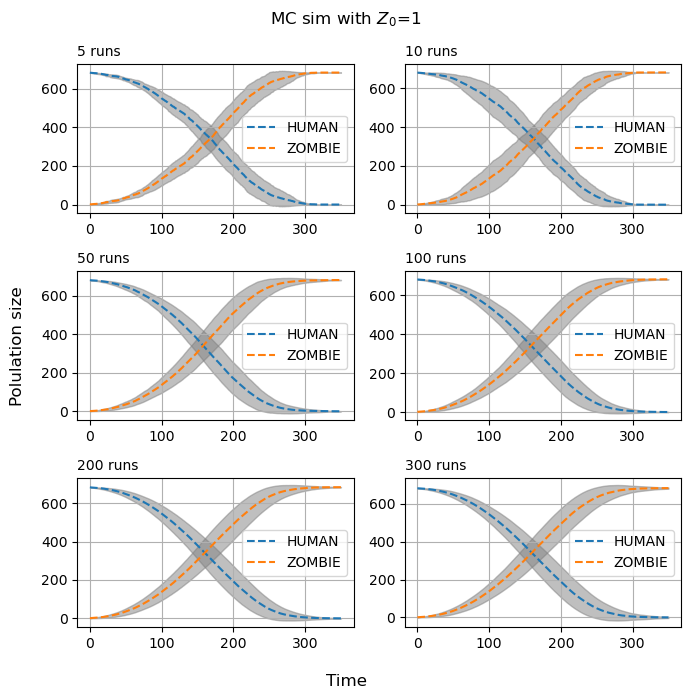

In [12]:
sizes = [5,10,50,100,200,300]
z0,T =1,350
fig, axs = plt.subplots(nrows = 3, ncols=2, figsize = (7,7))
axs = np.ndarray.flatten(axs)
for size,ax in zip(sizes,axs): 
    a = time.time()
    mc_averaged_data = run_mc(samples=size, infected=z0,T=T)
    plot_mc_results(ax, mc_averaged_data)
    ax.set_title(f'{size} runs', loc ='left', fontsize = 10)
    b = time.time()
    print(f'time taken to run {size} simulations = {b-a:.2f}s')
fig.suptitle(f'MC sim with $Z_0$={z0}')
fig.supxlabel('Time')
fig.supylabel('Polulation size')
plt.tight_layout()

time taken to run 5 simulations = 0.73s
time taken to run 10 simulations = 1.44s
time taken to run 50 simulations = 7.24s
time taken to run 100 simulations = 14.45s
time taken to run 200 simulations = 28.89s
time taken to run 300 simulations = 43.33s


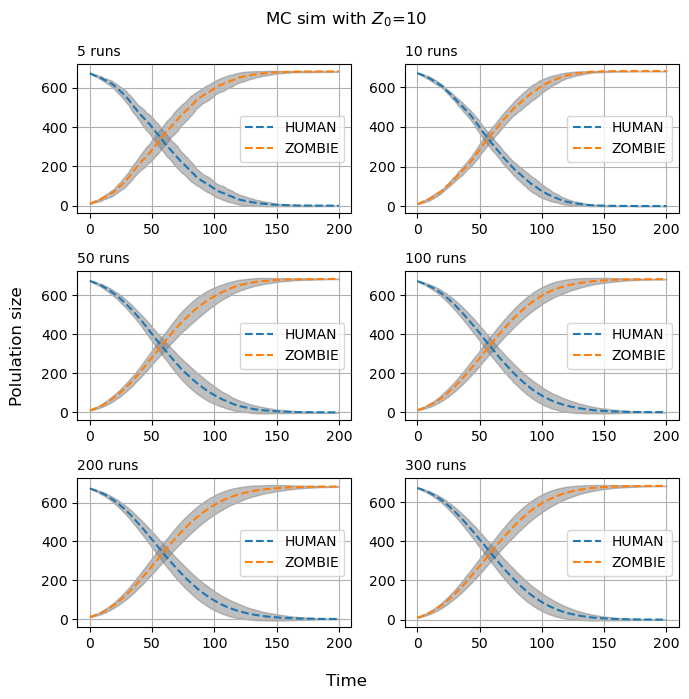

In [13]:
sizes = [5,10,50,100,200,300]
z0,T =10,200
fig, axs = plt.subplots(nrows = 3, ncols=2, figsize = (7,7))
axs = np.ndarray.flatten(axs)
for size,ax in zip(sizes,axs): 
    a = time.time()
    mc_averaged_data = run_mc(samples=size, infected=10,T=200)
    plot_mc_results(ax, mc_averaged_data)
    ax.set_title(f'{size} runs', loc ='left', fontsize = 10)
    b = time.time()
    print(f'time taken to run {size} simulations = {b-a:.2f}s')
fig.suptitle(f'MC sim with $Z_0$={z0}')
fig.supxlabel('Time')
fig.supylabel('Polulation size')
plt.tight_layout()